# Matter Density Profile

This script composes the work "Perfis de densidade de matéria de aglomerados de galáxias" developded during a year for the Programa de Iniciação Científica PIBIC 2019/2020 of the Universidade de Brasília (UnB).

In this code we implemented the density profile $\rho(r)$ of dark matter halos and its logarithmic slope $dln(\rho)/dln(r)$ for different models existent in the literature, to be specific the Hernquist, NFW and Einasto profiles. For these models, we've also implemented other physical quantities which depend on the density profile, e.g., the surface mass density $\Sigma(x)$, average surface mass density $\bar{\Sigma}(x)$ and excess surface mass density $\Delta\Sigma(x)$, that are important to obtain weak lensing functions (such as convergence $\kappa(x)$, shear $\gamma(x)$ and reduced shear $g(x)$). 

We choose those models once some properties of them can be expressed by analytical functions. We have even implemented a combination of them with a mean density outer profile. Whenever possible, we compared our code results with the ones using the Colossus library and the Numcosmo library to check for precision and agreement. 

To make it organized, we have signaled with

###############################################################COLOSSUS

...

###############################################################

the parts of the code where we made use of the Colossus library. We have also signaled when a variable is obtained using the Colossus library by initiating it with 'COL' (e.g. COL_rho_HER) or when obtained by the script we wrote (i.e., the functions we implemented) by 'SCR' (e.g. SCR_rho_HER). 

We chose different colors to represent different profile models in the plots, such that we used cyan (c) and blue (b) for Herquist; magenta (m) and red (r) for NFW; and yellow (y) and green (g) for Einasto.

In the future, we intend to add an implementation for the DK14 profile and some other outer profile models available (such as power law, 2-halo etc). We also intend to integrate this code in the Numcosmo library, making use of its cosmological and statistical tools.

In [1]:
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import *
from scipy.integrate import quad
from mpmath import meijerg

############################################################### COLOSSUS
from colossus.cosmology import cosmology

from colossus.halo import profile_hernquist
from colossus.halo import profile_nfw
from colossus.halo import profile_einasto
from colossus.halo import profile_dk14

from colossus.halo import profile_outer
###############################################################

### List of Constants


speed of light $c = 2.99792458\times 10^6 km.s^{-1}$ ([PDG2018](https://pdg.lbl.gov/2018/reviews/rpp2018-rev-astrophysical-constants.pdf))

gravitational constant ($SI$ units) $G = 6.67428 \times 10^{-11} m^3.s^{-2}.kg^{-1}$ ([Luzum2011](https://link.springer.com/article/10.1007/s10569-011-9352-4))

heliocentric gravitational constant $(GM)_\odot = 1.3271244\times 10^{20} m^3.s^{-2}$ ([Luzum2011](https://link.springer.com/article/10.1007/s10569-011-9352-4))

solar mass $M_\odot = \frac{(GM)_\odot}{G}$ (as recommended in ([IUA2015](https://www.iau.org/administration/resolutions/general_assemblies/)))

kiloparsec $ 1 kpc = 1.0\times 10^3 pc = 3.08567758149 \times 10^{19} m$ ([PDG2018](https://pdg.lbl.gov/2018/reviews/rpp2018-rev-astrophysical-constants.pdf))

gravitational constant ($kpc km^2s^{-2}M_\odot^{-1}$ units) $G = G_{(SI)}\frac{M_\odot}{kpc} \times 10^{-6} kpc.km^2.s^{-2}.M_\odot^{-1}$

present day Hubble rate $H_0 = 1.0 \times 10^{-1}h.km.s^{-1}.kpc^{-1}$

present day critical density $\rho_{crit,0}= \frac{3 H_0^2}{8 \pi G} h^2.M_\odot.kpc^{-3}$

hubble distance $D_H = \frac{c}{H_0} kpc.h^{-1}$

In [2]:
light_speed = 2.99792458E6 # speed of light (km/s)
gravit_const_SI = 6.67428E-11 #gravitational constant (m^3.s^-2.kg^-1)
heliocentric_gravit_const = 1.3271244E20 #heliocentric gravitational constant (m^3.s^-2)
solar_mass = heliocentric_gravit_const/gravit_const_SI #solar mass (kg)
kiloparsec = 3.08567758149E19 #kiloparsec (m)
gravit_const = gravit_const_SI/kiloparsec*solar_mass*1.0E-6 #gravitational constant (kpc.km^2.s^-2.M_\odot^-1)
hubble_rate0 = 1.0E-1 #presente day Hubble rate (h.km.s^-1.kpc-1)
crit_density0 = (3.0*hubble_rate0**2.0)/(8.0*np.pi*gravit_const) #critical density (M_\odot.h^2.kpc^-3)
hubble_distance = light_speed/hubble_rate0 #hubble distante (kpc/h)

### Cosmological Model


Here we set the cosmological model. We basically need to specify the cosmological parameters $\Omega_{m,0}$, $\Omega_{\gamma,0}$, $\Omega_{k,0}$ and $\Omega_{\Lambda,0}$.

In [3]:
###############################################################COLOSSUS
cosmo = cosmology.setCosmology('planck15');
print(cosmo)
###############################################################

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [4]:
Omega_m0 = cosmo.Om0
Omega_Lambda0 = cosmo.Ode0
Omega_gamma0 = 0
Omega_k0=  0

### Halo Definitions

We also need to input the overdensity definition $\Delta$, mass of the given overdensity $M_\Delta$, concentration $c_\Delta$, redshift $z$ and radius range we want to study $r$.

In [5]:
mass_def = '200m' #exs: 180m, 200m
M_Delta = 1.0E15 #mass of the given overdensity (M_\odot/h)
c = 4.0 #concentration
z = 1.0 #redshift

r = 10**np.arange(0,4.0,0.01) #radius range (kpc)

### Cosmology - Functions

normalized Hubble expansion rate at reshift z:
\begin{equation}
    E(z) = \sqrt{\Omega_{m,0}(1+z)^3 + \Omega_{\gamma,0}(1+z)^4 + \Omega_{k,0}(1+z)^2 + \Omega_{\Lambda,0}}
\end{equation}

mass density of the universe at reshift z:
\begin{equation}
\label{rhoMEAN}
    \rho_m(z) = \rho_{crit,0}\Omega_{m,0}(1+z)^3
\end{equation}

In [6]:
#normalized Hubble expansion rate at reshift z
def E_z(z):
	zp1 = 1.0+z
	return np.sqrt(Omega_m0*zp1**3.0+Omega_gamma0*zp1**4.0+Omega_k0*zp1**2.0+Omega_Lambda0)

#mass density of the universe at redshift z (M_\odot.h^2.kpc^-3)
def rho_m(z):
	return crit_density0*Omega_m0*(1.0+z)**3.0

### Overdensity - Functions

density of the overdensity:
$$\rho_{\Delta}  = \Delta \rho_m$$

radius of the overdensity:
$$r_{\Delta}  = \left(\frac{3M_\Delta}{4\pi\rho_\Delta}\right)^\frac{1}{3} $$

In [7]:
#density of the given overdensity (M_\odot.h^2.kpc^-3)
def rho_Delta(mass_def, z):
	Delta = float(mass_def[:-1])
	rho_Delta = Delta*rho_m(z)
	return rho_Delta

#radius of the given overdensity (kpc/h)
def r_Delta(M_Delta, rho_Delta):
	return ((3.0*M_Delta)/(4.0*np.pi*rho_Delta))**(1.0/3.0)

### Inner Profiles - Functions

#### Hernquist Profile

fundamental parameters:
\begin{equation}
    r_s = \frac{r_\Delta}{c}
\end{equation}
\begin{equation}
    \rho_s = \frac{2}{3}\rho_\Delta c(1+c)^2,
\end{equation}

density profile:
\begin{equation}
    \rho_{HER}(r) = \frac{\rho_s}{\left(\frac{r}{r_s}\right)\left(1+\left(\frac{r}{r_s}\right)\right)^3}
\end{equation}

linear derivative:
\begin{equation}
    \frac{d}{dr}\rho_{HER}(r)=-\rho_{HER}\frac{\frac{1}{r_s}\left(1+\frac{r}{r_s}\right)+3\frac{r}{r_s^2}}{\frac{r}{r_s}\left(1+\frac{r}{r_s}\right)},
\end{equation}

logarithmic derivative:
\begin{equation}
    \frac{d ln(\rho_{HER})}{dln(r)}= -\left[1+\frac{3\frac{r}{r_s}}{\left(1+\frac{r}{r_s}\right)}\right],
\end{equation}

In [8]:
#(inner) Hernquist density profile fundamental parameters
def parametersHernquist(rho_Delta, r_Delta, c):
	r_s = r_Delta/c
	rho_s = (2.0*rho_Delta*c*(1.0+c)**2.0)/3.0
	return r_s, rho_s

#(inner) Hernquist density profile
def rhoHernquist(r_s, rho_s, r):
	x = r/r_s
	rho = rho_s/(x*(1.0+x)**3.0)
	return rho

#(inner) Hernquist density profile linear derivative
def drho_drHernquist(r_s, r, rho):
	x = r/r_s
	return -rho*((1.0/r_s)*(1.0+x)+3.0*x/r_s)/(x*(1.0+x))

#(inner) Hernquist density profile logarithmic derivative
def logSlopeHernquist(r_s, r):
	x=r/r_s
	logSlope=-(1.0+3.0*x/(1.0+x))
	return logSlope

#### NFW Profile

fundamental parameters:
\begin{equation}
r_s = \frac{r_\Delta}{c}
\end{equation}
\begin{equation}
    \rho_s = \frac{1}{3}\rho_\Delta\frac{c^3}{ln(1+c)-\frac{c}{1+c}},
\end{equation}

density profile:
\begin{equation}
    \rho_{NFW}(r) = \frac{\rho_s}{\left(\frac{r}{r_s}\right)\left(1+\left(\frac{r}{r_s}\right)\right)^2}
\end{equation}

linear derivative:
\begin{equation}
    \frac{d}{dr}\rho_{NFW}(r)=-\rho_{NFW}\frac{\frac{1}{r_s}\left(1+\frac{r}{r_s}\right)+2\frac{r}{r_s^2}}{\frac{r}{r_s}\left(1+\frac{r}{r_s}\right)},
\end{equation}

logarithmic derivative:
\begin{equation}
    \frac{d ln(\rho_{NFW})}{dln(r)}= -\left[1+\frac{2\frac{r}{r_s}}{\left(1+\frac{r}{r_s}\right)}\right]
\end{equation}

In [9]:
#(inner) NFW density profile fundamental parameters
def parametersNFW(rho_Delta, r_Delta, c):
	r_s = r_Delta/c
	rho_s = (rho_Delta*c**3.0)/(3.0*(np.log(1.0+c)-c/(1.0+c)))
	return r_s, rho_s

#(inner) NFW density profile
def rhoNFW(r_s, rho_s, r):
	x = r/r_s
	return rho_s/(x*(1.0+x)**2.0)

#(inner) NFW density profile linear derivative
def drho_drNFW(r_s, r, rho):
	x = r/r_s
	return -rho*((1.0/r_s)*(1.0+x)+2.0*x/r_s)/(x*(1+x))

#(inner) NFW density profile logarithmic derivative
def logSlopeNFW(r_s, r):
	x = r/r_s
	return -(1.0+2.0*x/(1.0+x))

#### Einasto Profile

fundamental parameters:
\begin{equation}
r_s = \frac{r_\Delta}{c}
\end{equation}

\begin{equation}
    \rho_s =
    \frac{c^3 \rho_\Delta\alpha^{1-\frac{3}{\alpha}}2^\frac{3}{\alpha}}{3e^\frac{2}{\alpha} \Gamma\left(\frac{3}{\alpha}\right)P\left(\frac{3}{\alpha},\frac{2c^\alpha}{\alpha}\right)}
\end{equation}

density profile:
\begin{equation}
    \rho_{Einasto}(r)=\rho_s exp\left\{\frac{-2}{\alpha}\left[\left(\frac{r}{r_s}\right)^\alpha - 1 \right]\right\}
\end{equation}

linear derivative:
\begin{equation}
    \frac{d}{dr}\rho_{EIN}(r) = -\frac{2}{r}\rho_{EIN}\left(\frac{r}{r_s}\right)^\alpha,
\end{equation}

logarithmic derivative::
\begin{equation}
    \frac{d ln(\rho_{Einasto})}{dln(r)} = -2\left(\frac{r}{r_s}\right)^\alpha
\end{equation}

In [10]:
#(inner) NFW density profile fundamental parameters
def parametersEinasto(alpha, rho_Delta, r_Delta, c):
	r_s = r_Delta/c
	rho_s = (alpha**(1.0-3.0/alpha)*rho_Delta*c**3.0*2.0**(3.0/alpha))/(3.0*np.exp(2.0/alpha)*\
		gamma(3.0/alpha)*gammainc(3.0/alpha,(2.0*c**alpha)/alpha))
	return r_s, rho_s

#(inner) Einasto density profile
def rhoEinasto(alpha, r_s, rho_s, r):
	rho = rho_s*np.exp(-2.0*((r/r_s)**alpha-1.0)/alpha)
	return rho

#(inner) Einasto density profile linear derivative
def drho_drEinasto (alpha, r_s, r, rho):
	return -2.0*rho*(r/r_s)**alpha/r

#(inner) Einasto density profile logarithmic derivative
def logSlopeEinasto(alpha, r_s, r):
	logSlope = -2.0*(r/r_s)**alpha
	return logSlope

### Outer Profiles

There are different outer profile models available in the literature, such as the mean density, power law and 2-halo.

We've only implemented the mean density outer profile.

#### Mean Density Outer Profile

density profile:
$$ \rho_{OUT} = \rho_m(z) $$

In [11]:
def rhoOuterMean(z):
	return np.ones(len(r),np.float)*rho_m(z)

def drho_drOuterMean():
	return np.zeros(len(r),np.float)

### Total Profile

The total profile is the sum of the inner profile and the outer profile
\begin{equation}
    \rho_{TOT}(r) = \rho_{IN}(r) + \rho_{OUT}(r)
\end{equation}
and it's logarithmic derivative is given by
\begin{equation}
    \frac{d ln(\rho_{TOT})}{d ln(r)} = \frac{r}{\rho_{TOT}}\left[\frac{d\rho_{IN}}{dr}+\frac{d\rho_{OUT}}{dr}\right]
\end{equation}

In [12]:
def rhoTotal(rhoInner, rhoOuter):
	return rhoInner+rhoOuter

def logSlopeTotal(rhoTotal, drho_drInner, drho_drOuter, r):
	return (r/rhoTotal)*(drho_drInner+drho_drOuter)

### Calling the functions

In [13]:
###############################################################COLOSSUS
COL_profile_HER = profile_hernquist.HernquistProfile(M = M_Delta, c = c, z = z, mdef = mass_def)
COL_profile_NFW = profile_nfw.NFWProfile(M = M_Delta, c = c, z = z, mdef = mass_def)
COL_profile_EIN = profile_einasto.EinastoProfile(M = M_Delta, c = c, z = z, mdef = mass_def)

print('HER(inner):', COL_profile_HER.par)
print('NFW(inner):', COL_profile_NFW.par)
print('EIN(inner):', COL_profile_EIN.par)

COL_rho_m = cosmo.rho_m(z)

#HER
COL_rho_HER = COL_profile_HER.density(r)
COL_logSlope_HER = COL_profile_HER.densityDerivativeLog(r)

#NFW
COL_rho_NFW = COL_profile_NFW.density(r)
COL_logSlope_NFW = COL_profile_NFW.densityDerivativeLog(r)

#EIN
COL_rho_EIN = COL_profile_EIN.density(r)
COL_logSlope_EIN = COL_profile_EIN.densityDerivativeLog(r)
###############################################################

HER(inner): OrderedDict([('rhos', 9144646.843327926), ('rs', 300.71683361155294)])
NFW(inner): OrderedDict([('rhos', 3615208.7083061826), ('rs', 300.71683361155294)])
EIN(inner): OrderedDict([('rhos', 1050795.294235148), ('rs', 300.71683361155294), ('alpha', 0.4077539292152914)])


In [14]:
###############################################################COLOSSUS
COL_outer_MEAN = profile_outer.OuterTermMeanDensity(z = z)

COL_profile_HERplusMEAN = profile_hernquist.HernquistProfile(M = M_Delta, c = c, z = z, mdef = mass_def, outer_terms = [COL_outer_MEAN])
COL_profile_NFWplusMEAN = profile_nfw.NFWProfile(M = M_Delta, c = c, z = z, mdef = mass_def, outer_terms = [COL_outer_MEAN])
COL_profile_EINplusMEAN = profile_einasto.EinastoProfile(M = M_Delta, c = c, z = z, mdef = mass_def, outer_terms = [COL_outer_MEAN])

print('HER(inner+mean):', COL_profile_HERplusMEAN.par)
print('NFW(inner+mean):', COL_profile_NFWplusMEAN.par)
print('EIN(inner+mean):', COL_profile_EINplusMEAN.par)

#HER
COL_rho_HERplusMEAN = COL_profile_HERplusMEAN.density(r)
COL_logSlope_HERplusMEAN = COL_profile_HERplusMEAN.densityDerivativeLog(r)

#NFW
COL_rho_NFWplusMEAN = COL_profile_NFWplusMEAN.density(r)
COL_logSlope_NFWplusMEAN = COL_profile_NFWplusMEAN.densityDerivativeLog(r)

#EIN
COL_rho_EINplusMEAN = COL_profile_EINplusMEAN.density(r)
COL_logSlope_EINplusMEAN = COL_profile_EINplusMEAN.densityDerivativeLog(r)
###############################################################

HER(inner+mean): OrderedDict([('rhos', 9144646.843327926), ('rs', 300.71683361155294)])
NFW(inner+mean): OrderedDict([('rhos', 3615208.7083061826), ('rs', 300.71683361155294)])
EIN(inner+mean): OrderedDict([('rhos', 1045541.3177639722), ('rs', 300.71683361155294), ('alpha', 0.4077539292152914)])


In [15]:
SCR_rho_m = rho_m(z)

SCR_rho_Delta = rho_Delta(mass_def, z)
SCR_r_Delta = r_Delta(M_Delta, SCR_rho_Delta)

#HER
r_sHER, rho_sHER = parametersHernquist(SCR_rho_Delta, SCR_r_Delta, c)
SCR_rho_HER = rhoHernquist(r_sHER, rho_sHER, r)
SCR_drho_dr_HER = drho_drHernquist(r_sHER, r, SCR_rho_HER)
SCR_logSlope_HER = logSlopeHernquist(r_sHER, r)

#NFW
r_sNFW, rho_sNFW = parametersNFW(SCR_rho_Delta, SCR_r_Delta, c)
SCR_rho_NFW = rhoNFW(r_sNFW, rho_sNFW, r)
SCR_drho_dr_NFW = drho_drNFW(r_sNFW,r, SCR_rho_NFW)
SCR_logSlope_NFW = logSlopeNFW(r_sNFW, r)

#EIN
alpha = COL_profile_EIN.par['alpha'] #once we haven't implemented a function to obtain alpha, we used the one from Colossus
r_sEIN, rho_sEIN = parametersEinasto(alpha, SCR_rho_Delta, SCR_r_Delta, c)
SCR_rho_EIN = rhoEinasto(alpha, r_sEIN, rho_sEIN, r)
SCR_drho_dr_EIN = drho_drEinasto(alpha, r_sEIN, r, SCR_rho_EIN)
SCR_logSlope_EIN = logSlopeEinasto(alpha, r_sEIN, r)

print('HER(inner):', r_sHER, rho_sHER)
print('NFW(inner):', r_sNFW, rho_sNFW)
print('EIN(inner):', r_sEIN, rho_sEIN)

HER(inner): 300.71683361155306 9144646.843327908
NFW(inner): 300.71683361155306 3615208.708306175
EIN(inner): 300.71683361155306 1050795.2942351457


In [16]:
SCR_rho_MEAN = rhoOuterMean(z)
SCR_drho_dr_MEAN = drho_drOuterMean()

#HER
SCR_rho_HERplusMEAN = rhoTotal(SCR_rho_HER, SCR_rho_MEAN)
SCR_logSlope_HERplusMEAN = logSlopeTotal(SCR_rho_HERplusMEAN, SCR_drho_dr_HER, SCR_drho_dr_MEAN, r)

#NFW
SCR_rho_NFWplusMEAN = rhoTotal(SCR_rho_NFW, SCR_rho_MEAN)
SCR_logSlope_NFWplusMEAN = logSlopeTotal(SCR_rho_NFWplusMEAN, SCR_drho_dr_NFW, SCR_drho_dr_MEAN, r)

#EIN
SCR_rho_EINplusMEAN = rhoTotal(SCR_rho_EIN, SCR_rho_MEAN)
SCR_logSlope_EINplusMEAN = logSlopeTotal(SCR_rho_EINplusMEAN, SCR_drho_dr_EIN, SCR_drho_dr_MEAN, r)

### Ploting the profiles and their logarithmic slopes

<Figure size 432x288 with 0 Axes>

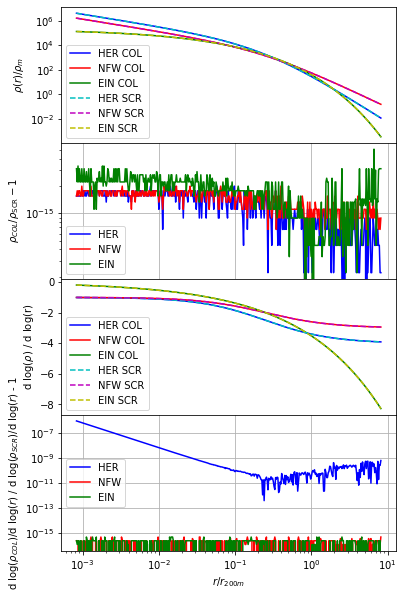

In [17]:
x=r/SCR_r_Delta

plt.figure()
fig, axs = plt.subplots (4, sharex=True, gridspec_kw={'hspace': 0}, figsize=(6,10))
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[3].set_yscale('log')
axs[3].set_xlabel('$r/r_{'+mass_def+'}$')
axs[0].set_ylabel(r'$\rho (r) / \rho_m$')
axs[1].set_ylabel(r'$\rho_{COL} / \rho_{\mathrm{SCR}} - 1$')
axs[2].set_ylabel(r'd log($\rho$) / d log(r)')
axs[3].set_ylabel(r'd log($\rho_{COL}$)/d log($r$) / d log($\rho_{SCR}$)/d log($r$) - 1')
#########################################################################COLOSSUS
axs[0].plot(x, COL_rho_HER/COL_rho_m, 'b-', label = 'HER COL')
axs[0].plot(x, COL_rho_NFW/COL_rho_m, 'r-', label = 'NFW COL')
axs[0].plot(x, COL_rho_EIN/COL_rho_m, 'g-', label = 'EIN COL')
#########################################################################
axs[0].plot(x, SCR_rho_HER/COL_rho_m,  'c--', label = 'HER SCR')
axs[0].plot(x, SCR_rho_NFW/COL_rho_m, 'm--', label = 'NFW SCR')
axs[0].plot(x, SCR_rho_EIN/COL_rho_m,  'y--', label = 'EIN SCR')
######################################################################### Comparison with Colossus
axs[1].plot(x, np.abs (COL_rho_HER/SCR_rho_HER - 1.0), 'b-', label = "HER")
axs[1].plot(x, np.abs (COL_rho_NFW/SCR_rho_NFW  - 1.0), 'r-', label = "NFW")
axs[1].plot(x, np.abs (COL_rho_EIN/SCR_rho_EIN - 1.0), 'g-', label = "EIN")
#########################################################################
#########################################################################COLOSSUS
axs[2].plot(x, COL_logSlope_HER, 'b-', label = 'HER COL');
axs[2].plot(x, COL_logSlope_NFW, 'r-', label = 'NFW COL');
axs[2].plot(x, COL_logSlope_EIN, 'g-', label = 'EIN COL');
#########################################################################
axs[2].plot(x, SCR_logSlope_HER,'c--', label='HER SCR')
axs[2].plot(x, SCR_logSlope_NFW,'m--', label='NFW SCR')
axs[2].plot(x, SCR_logSlope_EIN, 'y--', label='EIN SCR')
######################################################################### Comparison with Colossus
axs[3].plot(x, np.abs(COL_logSlope_HER/SCR_logSlope_HER-1.0), 'b-', label = "HER")
axs[3].plot(x, np.abs(COL_logSlope_NFW/SCR_logSlope_NFW-1.0), 'r-', label = "NFW")
axs[3].plot(x, np.abs(COL_logSlope_EIN/SCR_logSlope_EIN-1.0), 'g-', label = "EIN")
#########################################################################
axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[2].legend(loc='best')
axs[3].legend(loc='best')
axs[1].grid()
axs[3].grid()
plt.savefig('profiles1')
plt.show ()

<Figure size 432x288 with 0 Axes>

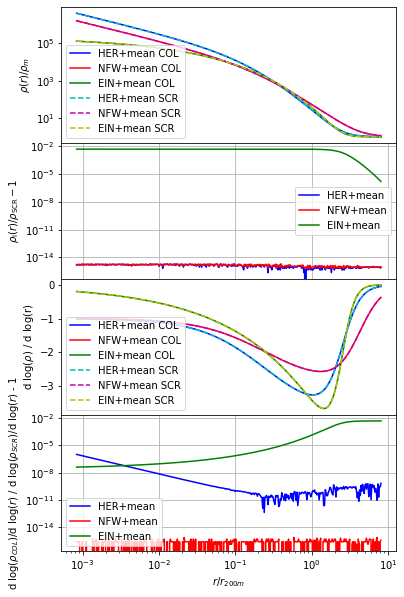

In [18]:
plt.figure()
fig, axs = plt.subplots (4, sharex=True, gridspec_kw={'hspace': 0}, figsize=(6,10))
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[3].set_yscale('log')
axs[3].set_xlabel('$r/r_{'+mass_def+'}$')
axs[0].set_ylabel(r'$\rho (r) / \rho_m$')
axs[1].set_ylabel(r'$\rho_{\mathrm{i}} (r) / \rho_{\mathrm{SCR}} - 1$')
axs[2].set_ylabel(r'd log($\rho$) / d log(r)')
axs[3].set_ylabel(r'd log($\rho_{COL}$)/d log($r$) / d log($\rho_{SCR}$)/d log($r$) - 1')
#########################################################################COLOSSUS
axs[0].plot(x, COL_rho_HERplusMEAN/COL_rho_m, 'b-', label = 'HER+mean COL')
axs[0].plot(x, COL_rho_NFWplusMEAN/COL_rho_m, 'r-', label = 'NFW+mean COL')
axs[0].plot(x, COL_rho_EINplusMEAN/COL_rho_m, 'g-', label = 'EIN+mean COL')
#########################################################################
axs[0].plot(x, SCR_rho_HERplusMEAN/COL_rho_m,  'c--', label = 'HER+mean SCR')
axs[0].plot(x, SCR_rho_NFWplusMEAN/COL_rho_m, 'm--', label = 'NFW+mean SCR')
axs[0].plot(x, SCR_rho_EINplusMEAN/COL_rho_m,  'y--', label = 'EIN+mean SCR')
######################################################################### Comparison with Colossus
axs[1].plot(x, np.abs (COL_rho_HERplusMEAN/SCR_rho_HERplusMEAN - 1.0), 'b-', label = "HER+mean")
axs[1].plot(x, np.abs (COL_rho_NFWplusMEAN/SCR_rho_NFWplusMEAN  - 1.0), 'r-', label = "NFW+mean")
axs[1].plot(x, np.abs (COL_rho_EINplusMEAN/SCR_rho_EINplusMEAN - 1.0), 'g-', label = "EIN+mean")
#########################################################################
#########################################################################COLOSSUS
axs[2].plot(x, COL_logSlope_HERplusMEAN, 'b-', label = 'HER+mean COL');
axs[2].plot(x, COL_logSlope_NFWplusMEAN, 'r-', label = 'NFW+mean COL');
axs[2].plot(x, COL_logSlope_EINplusMEAN, 'g-', label = 'EIN+mean COL');
#########################################################################
axs[2].plot(x, SCR_logSlope_HERplusMEAN,'c--', label='HER+mean SCR')
axs[2].plot(x, SCR_logSlope_NFWplusMEAN,'m--', label='NFW+mean SCR')
axs[2].plot(x, SCR_logSlope_EINplusMEAN, 'y--', label='EIN+mean SCR')
######################################################################### Comparison with Colossus
axs[3].plot(x, np.abs(COL_logSlope_HERplusMEAN/SCR_logSlope_HERplusMEAN-1.0), 'b-', label = "HER+mean")
axs[3].plot(x, np.abs(COL_logSlope_NFWplusMEAN/SCR_logSlope_NFWplusMEAN-1.0), 'r-', label = "NFW+mean")
axs[3].plot(x, np.abs(COL_logSlope_EINplusMEAN/SCR_logSlope_EINplusMEAN-1.0), 'g-', label = "EIN+mean")
#########################################################################
axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[2].legend(loc='best')
axs[3].legend(loc='best')
axs[1].grid()
axs[3].grid()

plt.show ()

### Dark Matter Halos as gravitational lens

#### Hernquist lens

surface mass density:
\begin{equation}
\Sigma_{Hernquist}(x) = \frac{\rho_s r_s}{(1-x^2)^2} \left\{
\begin{matrix}
\left[(2 + x^2)\frac{sech^{-1} x}{\sqrt{1-x^2}} - 3\right] & 0 \le x \le 1,\\
\left[(2 + x^2)\frac{sec^{-1} x}{\sqrt{x^2-1}} - 3\right] & x \ge1
\end{matrix}
\right.
\end{equation}

average surface mass density:
\begin{equation}
\bar{\Sigma}_{Hernquist}(x) = 2\rho_s r_s\left[\frac{1}{x^2}+\frac{1}{1-x^2} \left\{
\begin{matrix}
\left(\frac{sech^{-1}x}{\sqrt{1-x^2}}-\frac{1}{x^2}\right) & 0 \le x \le 1,\\
\left(\frac{sec^{-1}x}{\sqrt{x^2-1}}-\frac{1}{x^2}\right) & x \ge 1
\end{matrix}\right]\right.
\end{equation}

In [19]:
def sigmaHernquist(r_s, rho_s, r):
	x = r/r_s
	sigma = np.ones_like(x)

	reg1 = (x <= 1.0)
	reg2 = (x > 1.0)

	sigma[reg1] = rho_s*r_s*((2.0+x[reg1]**2.0)*np.arccosh(1.0/x[reg1])/np.sqrt(1.0-x[reg1]**2.0)- 3.0)/(1.0-x[reg1]**2.0)**2.0
	sigma[reg2] = rho_s*r_s*((2.0+x[reg2]**2.0)*np.arccos(1.0/x[reg2])/np.sqrt(x[reg2]**2.0-1.0)- 3.0)/(1.0-x[reg2]**2.0)**2.0
		
	return sigma

def barSigmaHernquist(r_s, rho_s, r):
	x = r/r_s
	barSigma = np.ones_like(x)

	reg1 = (x <= 1.0) 
	reg2 = (x > 1.0)
    
	barSigma[reg1] = 2*rho_s*r_s*((np.arccosh(1.0/x[reg1])/np.sqrt(1.0-x[reg1]**2.0)-1.0/x[reg1]**2)/(1.0-x[reg1]**2.0)+1.0/x[reg1]**2)
	barSigma[reg2] = 2*rho_s*r_s*((np.arccos(1.0/x[reg2])/np.sqrt(x[reg2]**2.0-1.0)-1.0/x[reg2]**2)/(1.0-x[reg2]**2.0)+1.0/x[reg2]**2)

	return barSigma

#### NFW lens

surface mass density:
\begin{equation}
\Sigma_{NFW} (x) = 2\rho_s r_s\left\{
\begin{matrix}
\frac{1}{x^2-1}\left(1-\frac{2}{\sqrt{1-x^2}}tanh^{-1}\sqrt{\frac{1-x}{1+x}}\right) & x<1,\\
\frac{1}{3} & x=1, \\
\frac{1}{x^2-1}\left(1-\frac{2}{\sqrt{x^2-1}}tan^{-1}\sqrt{\frac{x-1}{1+x}}\right) & x>1
\end{matrix}
\right.
\end{equation}

average surface mass density:
\begin{equation}
\bar{\Sigma}_{NFW}(x) = 4\rho_s r_s \left\{
\begin{matrix}
\frac{1}{x^2}\left[\frac{2}{\sqrt{1-x^2}}tanh^{-1}\sqrt{\frac{1-x}{1+x}}+ln\left(\frac{x}{2}\right)\right] & x<1,\\
1+ ln\left(\frac{1}{2}\right) & x=1, \\
\frac{1}{x^2}\left[\frac{2}{\sqrt{x^2-1}}tan^{-1}\sqrt{\frac{x-1}{1+x}}+ln\left(\frac{x}{2}\right)\right] & x>1
\end{matrix}
\right.
\end{equation}

In [20]:
def sigmaNFW(r_s, rho_s, r):
	x = r/r_s
	sigma = np.ones_like(x)

	reg1 = (x < 1.0)
	reg2 = (abs(x - 1.0) < 1E-3)
	reg3 = (x > 1.0)

	sigma[reg1] = 2.0*rho_s*r_s/(x[reg1]**2-1)*(1-2/np.sqrt(1-x[reg1]**2)*np.arctanh(np.sqrt((1-x[reg1])/(1+x[reg1]))))
	sigma[reg2] = 2.0*rho_s*r_s/3.0
	sigma[reg3] = 2.0*rho_s*r_s/(x[reg3]**2-1)*(1-2/np.sqrt(x[reg3]**2-1)*np.arctan(np.sqrt((x[reg3]-1)/(1+x[reg3]))))

	return sigma

def barSigmaNFW(r_s, rho_s, r):
	x = r/r_s
	barSigma = np.ones_like(x)

	reg1 = (x < 1.0)
	reg2 = (abs(x - 1.0) < 1E-3)
	reg3 = (x > 1.0)

	barSigma[reg1] = 4.0*rho_s*r_s/x[reg1]**2.0*(2.0*np.arctanh(np.sqrt((1.0-x[reg1])/(1.0+x[reg1])))/np.sqrt(1.0-x[reg1]**2.0)+np.log(x[reg1]/2.0))
	barSigma[reg2] = 4.0*rho_s*r_s*(1.0+np.log(1.0/2.0))
	barSigma[reg3] = 4.0*rho_s*r_s/x[reg3]**2.0*(2.0*np.arctan(np.sqrt((x[reg3]-1.0)/(1.0+x[reg3])))/np.sqrt(x[reg3]**2.0-1.0)+np.log(x[reg3]/2.0))

	return barSigma

#### Einasto lens
If n=1/alpha is an integer or half-integer, we have the following analytical functions...

surface mass density:
\begin{equation}
\Sigma_{EIN}(x) = \frac{\rho_s r_se^{2n}\sqrt{n}}{(2\pi)^{n-1}(2n)^n} x G_{0,2n}^{2n,0}
\left(
\begin{matrix}
- \hfill \\ \mathbf{b}
\end{matrix}
\, \middle\vert \,
\frac{x^2}{(2n)^{2n}}
\right)
\end{equation}

average surface mass density:
\begin{equation}
\bar{\Sigma}_{EIN}(x) = \frac{\rho_s r_se^{2n}\sqrt{n}}{(2\pi)^{n-1}(2n)^n} x G^{2n,1}_{1,2n+1}\left(
\begin{matrix}
-\frac{1}{2} \hfill \\ \mathbf{b},-\frac{3}{2}
\end{matrix}
\, \middle\vert \,
\frac{x^2}{(2n)^{2n}}
\right)
\end{equation}

in which
\begin{equation}
    \mathbf{b} = \left\{\frac{1}{2n},\frac{2}{2n},...,\frac{2n-1}{2n},-\frac{1}{2}\right\}
\end{equation}
is a vector of size $2n$.

In [21]:
#only for n=1/alpha integer or half-integer
def sigmaEinasto(alpha, r_s, rho_s, r):
	sigma = np.zeros(len(r))
	G = np.zeros(len(r))

	n = int(2*1/alpha)/2
	b = [0]*int(2*n)
	for j in range(0,len(b)-1):
		b[j]=(j+1)/(2*n)
	b[len(b)-1]=-1.0/2.0

	x = r/r_s*(2*n)**n

	i = 0
	for j in x:
		G[i] = meijerg([[],[]], [b,[]], j**2.0/(2.0*n)**(2.0*n))
		sigma[i] = rho_s*r_s*np.exp(2.0*n)*np.sqrt(n)*j*G[i]/((2.0*np.pi)**(n-1.0)*(2.0*n)**n)
		i=i+1

	return sigma

# only for n=1/alpha integer or half-integer
def barSigmaEinasto(alpha,r_s,rho_s,r):
	barSigma = np.zeros(len(r))
	G = np.zeros(len(r))

	n = int(2*1/alpha)/2
	b = [0]*int(2*n)
	for j in range(0,len(b)-1):
		b[j] = (j+1)/(2*n)
	b[len(b)-1] = -1.0/2.0

	x = r/r_s*(2*n)**n

	i = 0
	for j in x:
		G[i] = meijerg([[-1/2],[]], [b,[-3/2]], j**2/(2*n)**(2*n))
		barSigma[i] = rho_s*r_s*np.exp(2*n)*np.sqrt(n)*j*G[i]/((2*np.pi)**(n-1)*(2*n)**n)
		i=i+1

	return barSigma

### Calling the functions

In [22]:
alpha = int(10*alpha)/10 #since the analytical function we've implemented is only valid for 1/alpha integer or half-integer

In [23]:
#########################################################################COLOSSUS
#HER
COL_Sigma_HER = COL_profile_HER.surfaceDensity(r)
COL_DeltaSigma_HER = COL_profile_HER.deltaSigma(r)
COL_barSigma_HER = COL_Sigma_HER + COL_DeltaSigma_HER

#NFW
COL_Sigma_NFW = COL_profile_NFW.surfaceDensity(r)
COL_DeltaSigma_NFW = COL_profile_NFW.deltaSigma(r)
COL_barSigma_NFW = COL_Sigma_NFW + COL_DeltaSigma_NFW

#EIN
COL_profile_EIN.par['alpha']=alpha 

COL_Sigma_EIN = COL_profile_EIN.surfaceDensity(r)
COL_DeltaSigma_EIN = COL_profile_EIN.deltaSigma(r)
COL_barSigma_EIN = COL_Sigma_EIN + COL_DeltaSigma_EIN
#########################################################################

In [24]:
#HER
SCR_Sigma_HER = sigmaHernquist(r_sHER, rho_sHER, r)
SCR_barSigma_HER = barSigmaHernquist(r_sHER, rho_sHER, r)
SCR_DeltaSigma_HER = SCR_barSigma_HER - SCR_Sigma_HER

#NFW
SCR_Sigma_NFW = sigmaNFW(r_sNFW, rho_sNFW, r)
SCR_barSigma_NFW = barSigmaNFW(r_sNFW, rho_sNFW, r) 
SCR_DeltaSigma_NFW = SCR_barSigma_NFW - SCR_Sigma_NFW

#EIN
SCR_Sigma_EIN = sigmaEinasto(alpha, r_sEIN, rho_sEIN, r)
SCR_barSigma_EIN = barSigmaEinasto(alpha, r_sEIN, rho_sEIN, r)
SCR_DeltaSigma_EIN = SCR_barSigma_EIN - SCR_Sigma_EIN

### Ploting $\Sigma$, $\bar{\Sigma}$ and $\Delta\Sigma$

<Figure size 432x288 with 0 Axes>

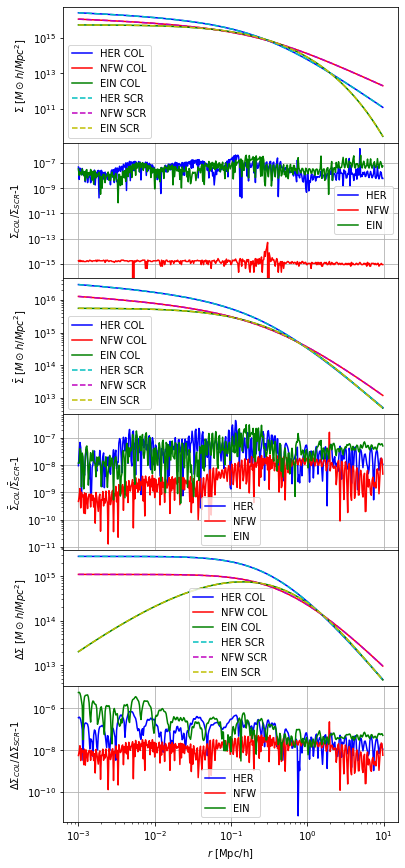

In [25]:
plt.figure()
fig, axs = plt.subplots (6, sharex=True, gridspec_kw={'hspace': 0}, figsize=(6,15))
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')
axs[3].set_yscale('log')
axs[4].set_yscale('log')
axs[5].set_yscale('log')
axs[5].set_xlabel('$r$ [Mpc/h]')
axs[0].set_ylabel('$\Sigma$ [$M\\odot h/Mpc^2$]')
axs[1].set_ylabel('$\\Sigma_{COL}$/$\\Sigma_{SCR}$-1')
axs[2].set_ylabel('$\\bar{\\Sigma}$ [$M\\odot h/Mpc^2$]')
axs[3].set_ylabel('$\\bar{\Sigma}_{COL}$/$\\bar{\\Sigma}_{SCR}$-1')
axs[4].set_ylabel('$\\Delta\\Sigma$ [$M\\odot h/Mpc^2$]')
axs[5].set_ylabel('$\\Delta\\Sigma_{COL}$/$\\Delta\\Sigma_{SCR}$-1')
#########################################################################COLOSSUS
axs[0].plot(r*1.0E-3, COL_Sigma_HER*1.0E6, 'b-', label = 'HER COL')
axs[0].plot(r*1.0E-3, COL_Sigma_NFW*1.0E6, 'r-', label = 'NFW COL')
axs[0].plot(r*1.0E-3, COL_Sigma_EIN*1.0E6, 'g-', label = 'EIN COL')
#########################################################################
axs[0].plot(r*1.0E-3, SCR_Sigma_HER*1.0E6, 'c--', label = 'HER SCR')
axs[0].plot(r*1.0E-3, SCR_Sigma_NFW*1.0E6, 'm--', label = 'NFW SCR')
axs[0].plot(r*1.0E-3, SCR_Sigma_EIN*1.0E6, 'y--', label = 'EIN SCR')
######################################################################### Comparison with Colossus
axs[1].plot(r*1.0E-3, np.abs(COL_Sigma_HER/SCR_Sigma_HER-1), 'b-', label = 'HER')
axs[1].plot(r*1.0E-3, np.abs(COL_Sigma_NFW/SCR_Sigma_NFW-1), 'r-', label = 'NFW')
axs[1].plot(r*1.0E-3, np.abs(COL_Sigma_EIN/SCR_Sigma_EIN-1), 'g-', label = 'EIN')
#########################################################################
#########################################################################COLOSSUS
axs[2].plot(r*1.0E-3, COL_barSigma_HER*1.0E6, 'b-', label = 'HER COL')
axs[2].plot(r*1.0E-3, COL_barSigma_NFW*1.0E6, 'r-', label = 'NFW COL')
axs[2].plot(r*1.0E-3, COL_barSigma_EIN*1.0E6, 'g-', label = 'EIN COL')
#########################################################################
axs[2].plot(r*1.0E-3, SCR_barSigma_HER*1.0E6, 'c--', label = 'HER SCR')
axs[2].plot(r*1.0E-3, SCR_barSigma_NFW*1.0E6, 'm--', label = 'NFW SCR')
axs[2].plot(r*1.0E-3, SCR_barSigma_EIN*1.0E6, 'y--', label = 'EIN SCR')
######################################################################### Comparison with Colossus
axs[3].plot(r*1.0E-3, np.abs(COL_barSigma_HER/SCR_barSigma_HER-1), 'b-', label = 'HER')
axs[3].plot(r*1.0E-3, np.abs(COL_barSigma_NFW/SCR_barSigma_NFW-1), 'r-', label = 'NFW')
axs[3].plot(r*1.0E-3, np.abs(COL_barSigma_EIN/SCR_barSigma_EIN-1), 'g-', label = 'EIN')
#########################################################################
#########################################################################COLOSSUS
axs[4].plot(r*1.0E-3, COL_DeltaSigma_HER*1.0E6, 'b-', label = 'HER COL')
axs[4].plot(r*1.0E-3, COL_DeltaSigma_NFW*1.0E6, 'r-', label = 'NFW COL')
axs[4].plot(r*1.0E-3, COL_DeltaSigma_EIN*1.0E6, 'g-', label = 'EIN COL')
#########################################################################
axs[4].plot(r*1.0E-3, SCR_DeltaSigma_HER*1.0E6, 'c--', label = 'HER SCR')
axs[4].plot(r*1.0E-3, SCR_DeltaSigma_NFW*1.0E6, 'm--', label = 'NFW SCR')
axs[4].plot(r*1.0E-3, SCR_DeltaSigma_EIN*1.0E6, 'y--', label = 'EIN SCR')
######################################################################### Comparison with Colossus
axs[5].plot(r*1.0E-3, np.abs(COL_DeltaSigma_HER/SCR_DeltaSigma_HER-1), 'b-', label = 'HER')
axs[5].plot(r*1.0E-3, np.abs(COL_DeltaSigma_NFW/SCR_DeltaSigma_NFW-1), 'r-', label = 'NFW')
axs[5].plot(r*1.0E-3, np.abs(COL_DeltaSigma_EIN/SCR_DeltaSigma_EIN-1), 'g-', label = 'EIN')
#########################################################################
axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[2].legend(loc='best')
axs[3].legend(loc='best')
axs[4].legend(loc='best')
axs[5].legend(loc='best')
axs[1].grid()
axs[3].grid()
axs[5].grid()

plt.savefig('profiles2')
plt.show ()